# A Detailed Example of Estimating a Stochastic Frontier Model using Julia with the __`SFrontiers`__ Package

We use an example to go through the specification and estimation process of using __SFrontiers__ in a stochastic frontier (SF) analysis. The example is a cross-sectional stochastic production frontier model with the __normal and truncated-normal__ distribution assumptions. In addition, exogenous determinants are included in the model in the style of Wang (2002). We choose this elaborated model to showcase the features of __SFrontiers__.


## Model Setup

Consider the following setup:

$$
 \mathbf{y}  =  \mathbf{x} \beta + \mathbf{v} - \mathbf{u},
$$

where $\mathbf{y}$ is $(N\times 1)$, $\mathbf{x}$ is $(N\times k)$ and includes a column of 1 for intercept, and $\beta$ is $(k \times 1)$. $\mathbf{v}$ and $\mathbf{u}$ are from random variables assumed to follow certain distribution assumptions. 


We use $x_i$ (which is ($1 \times k$)) to denote the $i$th observation of $\mathbf{x}$. Other notations follow similarly. The specification of the Wang (2002) model is thus:

$$
\begin{aligned}
 y_i & = x_i \beta + \epsilon_i,\\
 \epsilon_i & = v_i - u_i,\\
 v_i & \sim N(0, \sigma_v^2),\\
 u_i & \sim N^+(\mu, \sigma_u^2),\\
 \mu & = z_i \delta \quad \mathrm{and} \quad \sigma_u^2  = \exp(z_i \gamma).
 \end{aligned}
$$
 
Here, $N^+(\mu, \sigma_u^2)$ denotes a _truncated normal distribution_ obtained by truncating the normal distribution $N(\mu, \sigma_u^2)$ from below at 0. The $\mu$ and $\sigma_u^2$ are thus the mean and the variance of the normal distribution _before_ the truncation. $z_i$ is a vector of exogenous determinants of inefficiency. Wang (2002) parameterizes both $\mu$ and $\sigma_u^2$ by the same vector of $z_i$ while Battese and Coelli (1995) only parameterize $\mu$.

Note that the variance parameters $\sigma_v^2$ and $\sigma_u^2$ are parameterized using exponential functions to ensure positive values. In the case of $\sigma_v^2$,

$$
  \sigma_v^2 = \exp(c_v),
$$

where $c_v \in R$ is an unconstrained constant, and the log-likelihood maximization is w.r.t. $c_v$ (among others).

## goal of estimation

Our goals of the model estimation include:
- estimate model parameters $\{\beta, \delta, \gamma, \sigma_v^2  \}$,
- compute the inefficiency index $E[u_i | \epsilon_i]|_{\epsilon_i =\hat{\epsilon}_i}$ and the efficiency index $E[\exp(-u_i) | \epsilon_i]|_{\epsilon_i =\hat{\epsilon}_i}$ at the observation level,
- calculate the marginal effect of $z_i$ on $E(u_i)$.

##  1: Giving Model Specification using `sfmodel_spec()`

We use the production data from paddy farmers in India as an empirical example. The $\mathbf{y}$ is the annual rice production and $\mathbf{x}$ is a vector of agricultural inputs. 

There are two ways to provide data to __Sfmodel__ for estimation. One is to use data from a [DataFrame](https://dataframes.juliadata.org/stable/) where column names of the data are variable names. The other is to use data from matrices or vectors. The latter is the likely scenario in simulation studies where we generate data matrices and feed them to the model. Different ways of providing data would require slightly different specifications of `sfmodel_spec()`. 

Since the farmers data is formatted, it is natural to use the [DataFrame](https://dataframes.juliadata.org/stable/) approach. We will show the matrix approach later.

### using DataFrame data

Our farmers dataset is in the `.csv` format, and we read it in using the [CSV](https://csv.juliadata.org/stable/) package and save it as a [DataFrame](https://dataframes.juliadata.org/stable/) with the name `df`.

Before start, we use the following line to change Julia's working directory to the place where the dataset (`sampledata.csv`) is saved. You may have to customize the path to suit your case.

In [1]:
cd("c:/your/dataset/folder/");   # your dataset location; note: "/" instead of "\"

Now we import packages and read the dataset.

In [2]:
using SFrontiers        # main packages
using DataFrames, CSV   # handling data

df = DataFrame(CSV.File("sampledata.csv")) 
df[!, :_cons] .= 1.0;         # append column _cons as a column of 1 

┌ Info: Precompiling SFrontiers [450466ac-e45e-40ce-9385-fade81a2016c]
└ @ Base loading.jl:1342


We append a column of 1 to `df` with the column name `_cons`. Adding this constant variable to the dataset is essential because we will use it to estimate constant parameters; more on this later. Before estimation, users should ensure that the data in `df` has been cleaned, i.e., it contains no missing values or any anomaly that may affect the estimation.

Let's see what is in the data.

In [3]:
describe(df)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,yvar,7.27812,3.58666,7.28586,9.80335,0,Float64
2,Lland,1.05695,-1.60944,1.14307,3.04309,0,Float64
3,PIland,0.146997,0.0,0.0,1.0,0,Float64
4,Llabor,6.84951,3.2581,6.72263,9.46622,0,Float64
5,Lbull,5.64161,2.07944,5.68358,8.37008,0,Float64
6,Lcost,4.6033,0.0,5.1511,8.73311,0,Float64
7,yr,5.38007,1,5.0,10,0,Int64
8,age,53.8856,26,53.0,90,0,Int64
9,school,2.02583,0,0.0,10,0,Int64


Now we give model information to __SFrontiers__ using `sfmodel_spec()`. Before we start: I take advantage of Julia's support of [unicode characters](https://docs.julialang.org/en/v1/manual/unicode-input/) and use a few math symbols in `SFrontiers` functions. They are not difficult to use, and they help to match codes to models in papers thus making the code easier to understand. Nevertheless, I provide ascii alias of those symbols that can be used as alternatives.

This function generates a (global) dictionary that is automatically remembered and used in subsequent commands. The following specification indicates a Wang (2002) type of model, i.e., one that has a truncated normal distribution on $u_i$ and both $\mu$ and $\sigma_u^2$ are parameterized by a vector of variables.

In [4]:
sfmodel_spec(sftype(prod), sfdist(trun),
             @depvar(yvar), 
             @frontier(Lland, PIland, Llabor, Lbull, Lcost, yr, _cons), 
             @μ(age, school, yr, _cons),
             @σᵤ²(age, school, yr, _cons),
             @σᵥ²(_cons), message=true);

A dictionary from sfmodel_spec() is generated.


- `sftype(prod)` indicates a production-frontier type of model. The alternative is `cost` for cost frontier where the composed error is $v_i + u_i$.
- `sfdist(trun)` specifies the truncated-normal distribution assumption on $u_i$. Alternatives include `half`, `expo`, and `trun_scaling`.
- `@depvar(.)` specifies the dependent variable.
- `@frontier(.)` specifies the list of variables used in the frontier equation (i.e., the data of $\mathbf{x}$). The variables are assumed to be linear in the equation.
- `@μ(.)` (or `@mu(.)`) specifies the variables of inefficiency determinants as a linear function in `μ`.
- `@σᵤ²(.)` (or `@sigma_u_2(.)`) and `@σᵥ²(.)` (or `@sigma_v_2(.)`) specify the variables to parameterize the variances. Here we include only the variable `_cons` in $\sigma_v^2$ so it is estimated as a constant.
- `message` determines whether to print the confirmation message of "`A dictionary from ...`". The default is `false`.

Note how the constant parameter $\sigma_v^2$ is estimated. Recall the programming trick of using $\sigma_v^2 = \exp(c_v)$ in the likelihood function. Here, $c_v$ is simply the coefficient of the `_cons` variable.  

>__`Note on intercepts and constant parameters:`__
    > __SFrontiers__ estimates intercepts and constant parameters as the coefficients of a constant variable. That is, if a parameter is constant, __SFrontiers__ requires a variable with values equal to 1. It is true for all equations.

### using matrix data (_alternative data input_)

As aforementioned, data for estimation could also come from matrix and vectors, though the syntax of `sfmodel_spec()` is slightly different. The following code snippet has a simple example where we generate data in matrix for a normal half-normal model, and use them in `sfmodel_spec()`. The number of observations is 300.

>```
>---- example of alternative data input ----
>using SFrontiers, Random, Distributions
>cons,  x,  v = ones(300,1),  [randn(300, 2) ones(300,1)],  randn(300,1)    
>disTN = TruncatedNormal(0.0, 1.0, 0.0, Inf)    # half-normal dist with std dev = 1
>u = rand(disTN, (300,1))                       # draw from half-normal r.v. 
>y = x*ones(3)*0.5 .+ v .- u
>sfmodel_spec(sftype(prod),  sfdist(half),   
>             depvar(y),  frontier(x),  σᵤ²(cons),  σᵥ²(cons))
>---- end of example ----             
>```             

Note that the only difference in the syntax is using the function type of equation names (e.g., `depvar()`) instead of the macro type names (e.g., `@depvar()`). The rest of the estimation procedures are the same.

> __`Note on @depvar( ) vs. depvar( ):`__
Macro type of equation names (`@depvar()`, `@frontier()`, `@μ()`, etc.) are used only when the arguments are column names from [DataFrames](https://dataframes.juliadata.org/stable/). For everything else, function type of equation names (`depvar()`, `frontier()`, `μ()`, etc.) are used.

## 2: Providing Initial Values using `sfmodel_init()` _(optional)_

Providing initial values is helpful in many cases though it is optional. You could skip it entirely or provide initial values only to a partial list of the equations. If missing (all or part of the equations), default values will be used. Currently, the default uses the OLS estimates as initial values for coefficients in `frontier()` and $0.1$ for all other parameters. Here we use a mixed strategy in this example.

In [5]:
b_ini = ones(4)*(0.1)

sfmodel_init(  # frontier(bb),             # skip and use default
             μ(b_ini),                     # as a vector
             σᵤ²(-0.1, -0.1, -0.1, -0.1),  # manually input the vector
             σᵥ²(-0.1), message=true);                  # scalar

A dictionary from sfmodel_init() is generated.


- The order of equations in `sfmodel_init()` is not important. You can put `μ()` before or after `σᵥ²()`, it does not matter.
- The function type of equation names (e.g., `frontier()`, `μ()`, etc.) are used in `sfmodel_init()`.
- Initial values specified in `σᵥ²()` is w.r.t. the $c_v$ as in $\sigma_v^2 = \exp(c_v)$. Put differently, the initial value is w.r.t. $\log(\sigma_v^2)$. If we put `σᵥ²(-0.1)`, it means we have in mind the initial value of $\sigma_v^2$ being $\exp(-0.1) = 0.905$.   

> __Note on name conflict:__
>    __SFrontiers__ uses names such as `μ`, `σᵥ²`, `gamma`, `depvar`, `frontier`, etc.. If the names were used elsewhere in the program for different purposes (for instance, using `μ` to denote the value of a parameter), or users import other packages that use the same names, the name conflicts would arise. Signs of the problem include error messages such as 
>>    MethodError: objects of type ... are not callable
>
>There are simple ways to workaround:
>    - Use fully qualified names. For instance, use `SFrontiers.σᵥ²` instead of `σᵥ²`.
>    - Use an alias if there is one. For instance, use `sigma_v_2` instead of `σᵥ²`. 
>
> Check out the section of `API Reference` for more information.

##  3: Choosing Maximization Options (and others) using `sfmodel_opt()` _(optional)_

The main purpose of this function is to choose options for the numerical maximization process, including the choice of optimization algorithms, the maximum number of iterations, the convergence criterion, and others. __SFrontiers__ uses Julia's [Optim](https://julianlsolvers.github.io/Optim.jl/stable/) package to do the maximization, though only a subset of [Optim](https://julianlsolvers.github.io/Optim.jl/stable/)'s options are directly accessible through `sfmodel_opt()`.

An effective estimation strategy for challenging optimization problems is to use a non-gradient algorithm in the first stage (`warmstart`) for a few iterations and then switch to gradient-based algorithms in the second stage (`main`) for speed and accuracy. __SFrontiers__ uses the two-step strategy by default.

This function is also optional. All or part of the specifications may be skipped. If missing, default values will be used. The following example uses the default values.


In [6]:
sfmodel_opt(warmstart_solver(NelderMead()),   
            warmstart_maxIT(400),
            main_solver(Newton()), 
            main_maxIT(2000), 
            tolerance(1e-8), 
            message=true);

A dictionary from sfmodel_opt() is generated.


- `warmstart_solver(NelderMead())`: specifies the `Nelder-Mead` algorithm (which is gradient-free) in the first stage estimation. Mind the braces "`()`" which is part of the algorithm name. Using a non-gradient algorithm in the first stage is recommended.
- `main_solver(Newton())`: specifies the `Newton` method (which uses 2nd derivatives, i.e., Hessian) in the second stage estimation. 
- `warmstart_maxIT(100)` and `main_maxIT(2000)`: the maximum numbers of iterations in the first and the second stage estimation.
- `tolerance(1e-8)`: set the convergence criterion concerning the absolute tolerance in the gradient to `1e-8`. For non-gradient algorithms, it controls the main convergence tolerance, which is solver-specific. This is a wrapper of [Optim](https://julianlsolvers.github.io/Optim.jl/stable/)'s `g_tol` option.

If the two-stage strategy is not desired, we can skip the `warmstart` stage by giving empty keyword values to the first stage options, such as `warmstart_solver()` or `warmstart_maxIT()`, or both. Note that if we skip the keywords (i.e., missing `warmstart_solver` or `warmstart_maxIT` entirely), the default will be reinstated. Again, the first stage estimation will only be skipped when empty values are explicitly given to the related options.

In addition to controlling the maximization procedures, `sfmodel_opt()` also provides options to control other things. They and their default values are the follows. 

* `table_format(text)`: specify the format to print coefficient tables on the screen after `sfmodel_fit()` is run. The choices include `text`, `html` (good for web-based notebooks such as Jupyter, Pluto), and `latex`.
* `banner(true)`: show banner to help visually identify the start of the estimation. 
* `verbose(true)`: show interim and final results.
* `ineff_index(true)`: compute the Jondrow et al. (1982) inefficiency index and the Battese and Coelli (1987) efficiency index.
* `marginal(true)`: calculate the marginal effect of the inefficiency determinants (if any) on the unconditional mean of inefficiency.

Turning the above options to `false` may sometimes be desirable, particularly in simulation settings.

##  4: Starting Model Maximization using `sfmodel_fit()`

Previous steps prepare the model, and now we are ready to estimate it. We use `sfmodel_fit()` to start the estimation, and it returns a dictionary containing __coefficient estimates__, __efficiency and inefficiency index__, __marginal effects of inefficiency determinants__, and other information of the model. In the following example, we save the returned dictionary in `res`.


In [7]:
res = sfmodel_fit(useData(df));  # df is the name of the DataFrame


###------------------------------------###
###  Estimating SF models using Julia  ###
###------------------------------------###

*********************************
       Model Specification:
*********************************
Model type: the non-monotonic model of Wang (2002, JPA), normal and truncated-normal

* In the case of type(cost), "- uᵢ" below is changed to "+ uᵢ".

yvar = frontier([:Lland, :PIland, :Llabor, :Lbull, :Lcost, :yr, :_cons]) + vᵢ - uᵢ,

where vᵢ ∼ N(0, σᵥ²),
           σᵥ² = exp(log_σᵥ²) 
               = exp([:_cons]);
      uᵢ ∼ N⁺(μ, σᵤ²),
           μ = [:age, :school, :yr, :_cons],
           σᵤ² = exp(log_σᵤ²) 
               = exp([:age, :school, :yr, :_cons]);

The warmstart run...


 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     2.525516e+02

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≰ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit In

- `useData(df)`: name of the DataFrame used in the 1st step

If the estimation data is from matrix and vectors, the `useData()` option should be omitted. That is, we do the following line.

```
res = sfmodel_fit();
```

## 5: Results and Post Estimation Analysis

As reminded in the printout, all of the shown statistics and many of the other model information are saved in the dictionary which can be called later for further investigation. We have saved it in `res`. Let's see the list of available keys.

In [8]:
keys(res)

(:converged, :iter_limit_reached, :_______________, :n_observations, :loglikelihood, :table, :coeff, :std_err, :var_cov_mat, :jlms, :bc, :OLS_loglikelihood, :OLS_resid_skew, :marginal, :marginal_mean, :_____________, :model, :depvar, :frontier, :μ, :σₐ², :σᵤ², :σᵥ², :log_σₐ², :log_σᵤ², :log_σᵥ², :type, :dist, :PorC, :timevar, :idvar, :table_format, :modelid, :verbose, :hasDF, :transfer, :coeff_frontier, :coeff_μ, :coeff_log_σᵤ², :coeff_log_σᵥ², :________________, :Hessian, :gradient_norm, :actual_iterations, :______________, :warmstart_solver, :warmstart_ini, :warmstart_maxIT, :main_solver, :main_ini, :main_maxIT, :tolerance, :eqpo, :redflag, :list)

Among the keywords is the term `:coeff`, which indicates the saved coefficient vector. We may retrieve the coefficient vector using `res.coeff` and save it in the name `b0` possibly for later use.

In [9]:
b0 = res.coeff

16-element Vector{Float64}:
  0.258215637381727
  0.17173767717858887
  1.1658044162241323
 -0.42146760550718915
  0.014239092238445777
  0.018252219995691023
  1.542939614477449
 -0.04790078238479355
 -0.21428860442344966
  0.14796117211956783
  1.0418278962122218
  0.025636024886922997
  0.11408617656111664
 -0.2255921665434172
 -1.1399135653517658
 -3.266714759389675

The estimation table shown above with the coefficients, standard errors, etc., may also be retrieved using the keyword `table`, though it may not be formatted as pretty.


### 5.1 hypothesis testing

We may conduct a likelihood ratio (LR) test to see if the data support the frontier specification. The null hypothesis is that the inefficiency term $u_i$ is not warranted, and the model's fit is no better than the OLS.

First, we calculate the test statistics using the log-likelihood values of the OLS model (keyword `OLS_loglikelihood`) and the current model (keyword `loglikelihood`).


In [10]:
-2*(res.OLS_loglikelihood - res.loglikelihood)

45.890250036982394

Because the test amounts to testing $u_i =0$ which is on the boundary of the parameter's support, the appropriate distribution for the test statistic is the mixed $\chi^2$ distribution. Critical values may be retrieved using `sfmodel_MixTable(dof)` where `dof` is the degree of freedom of the test. In this example, `dof=8` because there are five parameters involved in $u_i$.

In [11]:
sfmodel_MixTable(8)


  * Significance levels and critical values of the mixed χ² distribution
┌─────┬────────┬────────┬────────┬────────┐
│ dof │   0.10 │   0.05 │  0.025 │   0.01 │
├─────┼────────┼────────┼────────┼────────┤
│ 8.0 │ 12.737 │ 14.853 │ 16.856 │ 19.384 │
└─────┴────────┴────────┴────────┴────────┘

source: Table 1, Kodde and Palm (1986, Econometrica).


1×5 adjoint(::Vector{Float32}) with eltype Float32:
 8.0  12.737  14.853  16.856  19.384

Since the test statistic $45.888$ is much larger than the critical value at the $1\%$ level (which is $19.384$), the test overwhelmingly rejects the null hypothesis of an OLS model.

 ### 5.2 inefficiency and efficiency index

The Jondrow et al. (1982) inefficiency index and the Battese and Coelli (1987) efficiency index at the observation level may also be retrieved using the keywords `jlms` and `bc`. Here we show them in a $N\times 2$ matrix.


In [12]:
[res.jlms  res.bc]

271×2 Matrix{Float64}:
 0.571113  0.574409
 0.510028  0.6102
 0.103925  0.904532
 0.287701  0.758799
 0.151947  0.864143
 0.570984  0.574327
 0.548446  0.587125
 0.337604  0.722647
 0.913724  0.406824
 1.05388   0.354474
 0.136346  0.877187
 0.496905  0.618556
 0.235499  0.79831
 ⋮         
 0.113626  0.896217
 0.782824  0.465776
 0.94308   0.396787
 0.115819  0.894537
 0.237384  0.797287
 0.235514  0.798686
 1.17586   0.314258
 0.428381  0.662442
 0.847952  0.436286
 0.110013  0.899444
 0.175163  0.845745
 0.165558  0.853443

Let's do some graphical presentation on the index using the [Plots](http://docs.juliaplots.org/latest/) package. (You may have to add the package by `using Pkg; Pkg.add("Plots")`. The following code plots histograms of the index.

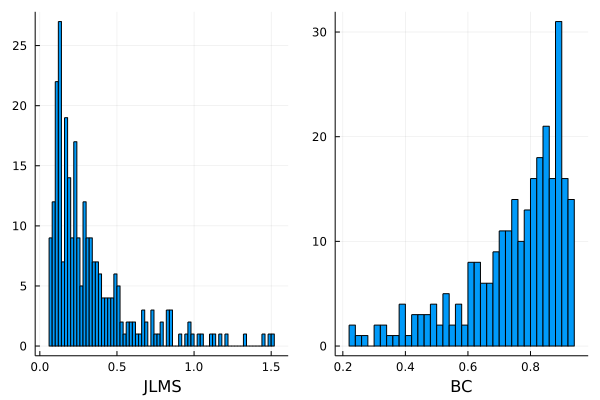

In [13]:
using Plots

h1 = histogram(res.jlms, xlabel="JLMS", bins=100, label=false)
h2 = histogram(res.bc, xlabel="BC", bins=50, label=false)
h1h2= plot(h1, h2, layout = (1,2), legend=false)

We may save the above figure to the disk for later use. Here we save it in the .svg format as `histPlot.svg`.

In [14]:
savefig(h1h2, "histPlot.svg")  # or .png, .pdf

 ### 5.3 marginal effects

Let's use the keyword `marginal` to see the marginal effects of the inefficient determinants on $E(u)$ at the observational level, which are saved in the returned dictionary as a [DataFrame](https://dataframes.juliadata.org/stable/) object.

In [15]:
res.marginal

,marg_age,marg_school,marg_yr
,Float64,Float64,Float64
1,-0.00522016,-0.023474,-0.0134693
2,-0.00636249,-0.0285745,-0.00756082
3,-0.00775711,-0.0348048,-0.00112862
4,-0.00953811,-0.0427643,0.00631516
5,-0.0119062,-0.0533508,0.0155006
6,-0.00860434,-0.0386115,-0.00255577
7,-0.0105773,-0.0474275,0.00597855
8,-0.0165443,-0.0741016,0.0293439
9,-0.021126,-0.0945861,0.0464716


We may also plot the marginal effect.

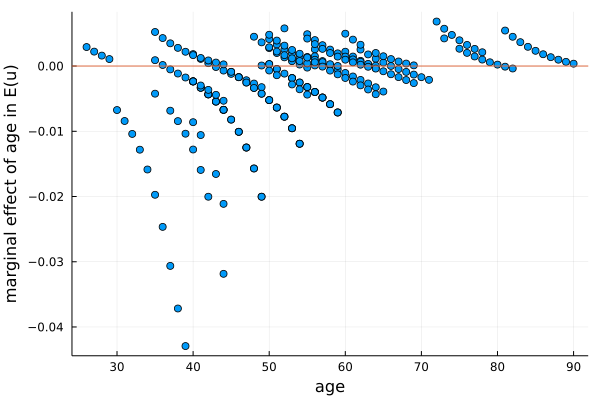

In [16]:
m1 = plot(df[:,:age], res.marginal[:,:marg_age], seriestype = :scatter, xlabel = "age", 
           ylabel = "marginal effect of age in E(u)", label = false)
hline!([0.00], label = false)

In [17]:
savefig(m1, "margAge.svg")

The plot indicates that production inefficiency decreased (efficiency improved) with age in the early years of the farmer’s life, perhaps because of experience accumulation. But the inefficiency increased with age in later years, perhaps due to deteriorated mental and physical health. Wang's (2002) model allows the non-monotonic effect to show in the data by parameterizing both of $\mu$ and $\sigma_u^2$ by the same vector of inefficiency determinants.

#### 5.3.1 bootstrapping standard errors and confidence intervals of the mean marginal effects

`sfmodel_fit()` calculates the means of the marginal effects and the values are reported in the printout: `* The sample mean of inefficiency determinants' marginal effects on E(u): 
(age = -0.00264, school = -0.01197, yr = -0.0265)`. We may bootstrap the standard errors and obtain confidence intervals of the mean marginal effects using `sfmodel_boot_marginal()`. As a demonstration, in this example we use only 100 bootstrapped samples (`R=100`) and restrict the iteration number to 100 (`iter=100`). We also save the bootstrapped data by specifying the option `getBootData=true` and catching it in `bsdata` from the second return of the function. The data would be $R \times K$ where $K=3$ in this example.

In [18]:
err_ci, bsdata = sfmodel_boot_marginal(result=res, data=df, R=100, seed=1232, iter=100, getBootData=true);

bootstrap in progress..10..20..30..40..50..60..70..80..90..100..Done!

┌────────┬──────────────────────┬─────────────────┬──────────────────────┐
│        │ mean of the marginal │ std.err. of the │       bias-corrected │
│        │       effect on E(u) │     mean effect │    95.0%  conf. int. │
├────────┼──────────────────────┼─────────────────┼──────────────────────┤
│    age │             -0.00264 │         0.00203 │  (-0.00738, 0.00114) │
│ school │             -0.01197 │         0.01212 │  (-0.03718, 0.01118) │
│     yr │             -0.02650 │         0.01224 │ (-0.04906, -0.00192) │
└────────┴──────────────────────┴─────────────────┴──────────────────────┘



- `result=res`: The returned result from `sfmodel_fit()` from the main estimation (in our example, `res`).
- `data=df`: The dataset (in DataFrame format) used in `sfmodel_fit()`. If data was supplied using matrix (i.e., the Method 2 of `sfmodel_spec()`), this option should be skipped.
- `R=100`: The number of bootstrapped samples.
- `level=0.05`: The significance level of the confidence intervals. Optional (so not shown in the above example) with the default value equal to 0.05.
- `seed=1232`: Optional. A positive integer used to seed the random number generator (rng) in resampling, which ensures reproducibility. This rng is not global and is effective only in this function. If not specified, the global random number generator is used, and the bootstrap result may change (slightly) between runs.
- `iter=100`: The iteration limit for each of the maximum likelihood estimation. The default is the one specified by `main_maxIT()` in `sfmodel_opt()`.
- `getBootData=true`: Whether to return the bootstrapped data which is ``R x K`` where K is the number of exogenous determinants of inefficiency. The default is `false`.

See help on `sfmodel_boot_marginal()` for other options.

In this example, the function has two returns. The first one, which we saved in `err_ci`, is a $3\times 2$ matrix with the bootstrapped standard errors in the first column and the confidence intervals (tuples) in the 2nd column. The second return, which we saved in `bsdata`, is a $100 \times 3$ matrix of bootstrapped data. More specifically, the first column is the bootstrapped mean marginal effect of `age` collected from each of the 100 replications. The second and the third columns are the data for `school` and `yr`, respectively.

If `getBootData=false` (the default), there would be only one return (the first one) from `sfmodel_boot_marginal()`.

The saved `bsdata` data could be used for later analysis. For instance, to obtain confidence intervals at different significance levels, we could re-run `sfmodel_boot_margina()` with different values of `level`, but this is time consuming and absolutely unnecessary since the bootstrapped data is the same regardless of the significance levels. Instead, we may run `sfmodel_boot_marginal()` once and obtain bootstrapped data, and then apply it to `sfmodel_CI()` to get confidence intervals at different significance levels.

Here we use `bsdata` in `sfmodel_CI()` to get the 90% bias-corrected confidence intervals (i.e., at the 10% significance level).

In [19]:
sfmodel_CI(bootdata=bsdata, observed=res.marginal_mean, level=0.10)


Bias-Corrected 90.0% Confidence Interval:



3×1 Matrix{Any}:
 (-0.00687, 0.00073)
 (-0.0316, 0.00695)
 (-0.04771, -0.00464)

- `bootdata=bsdata`: The bootstrapped data of size ``R x K``, where ``R`` is the number of bootstrap samples (replications) and    ``K`` is  the number of statistics.
- `observed=res.marginal_mean`: The observed values of the statistics to which the confidence intervals are to
  be calculated. It could be `Vector`, `Tuple`, or `NamedTuple`. The length of `observed` should be equal to ``K``. 
- `level=0.10`: The significance level (default=0.05) of the bias-corrected
  confidence intervals.
  
Note that here we used `observed=res.marginal_mean` where `res` is the model estimation results we obtained earlier from `res = sfmodel_fit(useData(df))`, and `marginal_mean` is a field of `res` containing the mean of the three exogenous inefficiency determinants' marginal effects. We could have manually input the mean effects, e.g., `observed=(-0.00264, -0.01197, -0.0265)`, and the result would be the same.

### 5.4 predicted values of equations

__SFrontiers__ provides the function `sfmodel_predict()` to obtain predicted values of model equations after the model is estimated. The following example returns the predicted value of the `frontier` equation, i.e., $\mathbf{x} \hat{\beta}$.

In [20]:
xb = sfmodel_predict(@eq(frontier), df)

271-element Vector{Float64}:
 5.870910806426072
 5.491526404135262
 5.162700470105734
 5.523503098102717
 6.112704104912208
 6.098751562179612
 5.815283919460376
 6.280737230829411
 6.037825679836788
 5.094897275381513
 4.758654316804428
 6.904518873318667
 6.098718158651797
 ⋮
 9.375890553184398
 9.19079584000254
 9.307779457085271
 8.897760277639787
 9.123504741556069
 8.973471393856101
 4.916534395536333
 6.4182373699711714
 8.208785622944891
 7.895417236050275
 8.549405592062568
 6.399603902613778

Note that `df` in the function is the name of the DataFrame which we had used to estimate the model. If matrix and vectors are used as data input, the argument can be skipped. The estimated composed error of the model, namely $\hat{\epsilon}_i = \hat{v}_i - \hat{u}_i$, is then obtained by `df[:, :yvar] - xb`.

Predicted values of other equations may be obtain in the similar way. For instance, `sfmodel_predict(@eq( σᵤ² ),df)`.

# 6. save results to disk

We may save the entire `res` dictionary or part of the results to the disk and load them later in other sessions for further analysis. There are several ways to do this. One is to save the dictionary in a binary file. Here we use the [JLD2](https://juliaio.github.io/JLD2.jl/stable/) package to save it in the HDF5 format.

In [21]:
using JLD2    # which saves objects in HDF5-based Julia Data Format

save_object("model1.jld2", res)       # save `res` dictionary to `model1.jld2`
result1 = load_object("model1.jld2")  # load it back to `result1`

save_object("model1_jlms.jld2", res.jlms)    # save only the JLMS inefficiency index
jlmsindex = load_object("model1_jlms.jld2")  # load it back to `jlmsindex`

271×1 Matrix{Float64}:
 0.5711125502477011
 0.5100279737945445
 0.10392499251096007
 0.28770138181054145
 0.1519472171765131
 0.5709842065572707
 0.548445815016095
 0.3376038283534645
 0.913723839514026
 1.0538799620415542
 0.13634564025988846
 0.4969046319068868
 0.2354992221131789
 ⋮
 0.11362566639260423
 0.7828243377849929
 0.9430804750376706
 0.11581937450155533
 0.23738390079711663
 0.23551399319896782
 1.1758613521386838
 0.42838120711250166
 0.8479517070885899
 0.11001281445856012
 0.175162891872597
 0.1655576143050841

It is also possible to save some of the results in the good old text format which is cross-platform, version compatible, human-readable, and likely superior for the purpose of long-term storage. Here we use `CSV.write()` function from the [CSV](https://csv.juliadata.org/stable/#CSV.write) package that we have loaded earlier. A limitation of the function is that it only saves table-like or matrix-like data. We may not save the entire `res` dictionary with it. 

In [22]:
   # save the marginal effects to `marginal.txt`
CSV.write("marginal.txt", res.marginal )  # res.marginal is a DataFrame

   # save the coefficient vector to `coeff.txt`
CSV.write("coeff.txt", 
           DataFrame(reshape(res.coeff, length(res.coeff), 1), :auto), 
           header=true)              # res.coeff is a vector

"coeff.txt"

Because `res.coeff` is a vector, it has to be converted into a matrix to use `CSV.write`. The `reshape()` bit is used for this purpose.
